In [1]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

In [3]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [4]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
import matplotlib.pyplot as plt
import torch

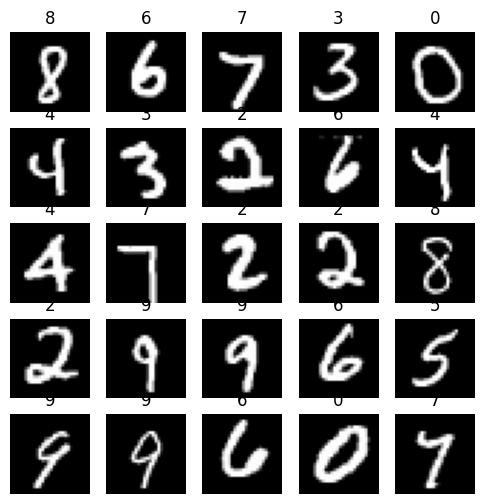

In [7]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
from torch.utils.data import DataLoader
import torch.nn as nn

In [9]:
train_dataloader = DataLoader(mnist_trainset, batch_size=20, shuffle=True, num_workers=4)
test_dataloader = DataLoader(mnist_testset, batch_size=20, shuffle=False, num_workers=4)

In [10]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(x.size(0), -1) #flattening the layer      
        output = self.out(x)
        return output

In [11]:
device = torch.device("cuda:0")
cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [12]:
loss_function = nn.CrossEntropyLoss()

In [13]:
from torch import optim
optimizer = optim.Adam(cnn_model.parameters(), lr=0.005)

In [14]:
def calculate_accuracy(model_output, target):
    
    predictions = torch.max(model_output, 1)[1].data.squeeze()
    
    accuracy = (predictions == target).sum().item()/float(target.size(0))
    return accuracy

In [15]:
def train_model(cnn_model, loss_function, optimizer, train_dataloader):
    
    num_epoch = 30
    cnn_model.train()
    
    for epoch in range(num_epoch):
        
        epoch_loss = 0
        epoch_accuracy = 0
        i = 0
        for i, (images, labels) in enumerate(train_dataloader):

            images, labels = images.to(device), labels.to(device)
            
            output = cnn_model(images)
            
            loss = loss_function(output, labels)
            
            optimizer.zero_grad() #releasing the cache
            
            loss.backward()
            epoch_loss += loss.item()
            
            epoch_accuracy += calculate_accuracy(output, labels)
            
            optimizer.step()
            
        
        print(f"Epoch: {epoch} - Loss: {epoch_loss} - Accuracy: {epoch_accuracy/(i+1)}")

In [16]:
train_model(cnn_model,loss_function, optimizer, train_dataloader)

Epoch: 0 - Loss: 319.33923370070625 - Accuracy: 0.9668499999999937
Epoch: 1 - Loss: 170.90116889694946 - Accuracy: 0.9830333333333298
Epoch: 2 - Loss: 148.06068058435795 - Accuracy: 0.9855833333333268
Epoch: 3 - Loss: 134.84086419338135 - Accuracy: 0.9869833333333281
Epoch: 4 - Loss: 127.30068282366261 - Accuracy: 0.9880999999999949
Epoch: 5 - Loss: 123.20399030489531 - Accuracy: 0.9890666666666613
Epoch: 6 - Loss: 124.39196819763818 - Accuracy: 0.9890333333333267
Epoch: 7 - Loss: 108.435889556687 - Accuracy: 0.990349999999994
Epoch: 8 - Loss: 120.48859958317279 - Accuracy: 0.9902666666666604
Epoch: 9 - Loss: 110.94485617936161 - Accuracy: 0.9918499999999953
Epoch: 10 - Loss: 126.6275244506918 - Accuracy: 0.9914499999999935
Epoch: 11 - Loss: 105.96457863769474 - Accuracy: 0.9929333333333278
Epoch: 12 - Loss: 109.20468810157085 - Accuracy: 0.9925333333333306
Epoch: 13 - Loss: 123.21456941608815 - Accuracy: 0.9927499999999952
Epoch: 14 - Loss: 120.20356931867867 - Accuracy: 0.99294999999

In [20]:
def test_model(cnn_model, test_dataloader):
    
    cnn_model.eval()
    
    accuracy = 0
    i = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images, labels = images.to(device), labels.to(device)
        output = cnn_model(images)
        accuracy += calculate_accuracy(output, labels)
        
    print(f"Test Accuracy: {accuracy/(i+1)}")

In [21]:
test_model(cnn_model, test_dataloader)

Test Accuracy: 0.9876999999999986


In [22]:
#save the model state
torch.save(cnn_model.state_dict(), './cnn_model.pth')